# Estimativa Salarial Usando Modelos de Regressão

## Imports

In [81]:
# Bibliotecas padrão
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from pathlib import Path

# Scikit-learn: Pré-processamento
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    FunctionTransformer, 
    LabelEncoder, 
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler
)
from sklearn.linear_model import LassoCV
from sympy import rf
# Scikit-learn: Divisão de dados
from sklearn.model_selection import (
    GridSearchCV, 
    KFold, 
    RandomizedSearchCV,
    cross_val_score,
    learning_curve, 
    train_test_split
)

# Scikit-learn: Modelos
from sklearn.ensemble import (
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor
)
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Modelos externos
from xgboost import XGBRegressor

# Scikit-learn: Métricas
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score
)

# Scikit-learn: Seleção de features
from sklearn.feature_selection import (
    RFECV,
    SelectFromModel,
    SelectKBest,
    SequentialFeatureSelector,
    f_regression,
)

# Scikit-learn: Pipeline
from sklearn.pipeline import Pipeline

# Scikit-learn: Inspeção de modelos
from sklearn.inspection import PartialDependenceDisplay

# Scikit-learn: Extração e redução de texto
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

## Dataset

In [82]:
data_path = Path("data_cleaned_2021.csv")
assert data_path.exists(), f"Arquivo não encontrado: {data_path}"

df = pd.read_csv(data_path)
assert not df.empty, "DataFrame está vazio"

df.replace({-1: np.nan}, inplace=True)

## Pré-processamento e limpeza

In [83]:
# Cria faixas para Rating
rating_bins = [0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
rating_labels = ['0 - 2.5', '2.6 - 3.0', '3.1 - 3.5', '3.6 - 4.0', '4.1 - 4.5', '4.6 - 5.0']
df['Rating_range'] = pd.cut(df['Rating'], bins=rating_bins, labels=rating_labels, include_lowest=True)

# Cria faixas para Age
age_bins = [0, 10, 20, 40, 60, 100, np.inf]
age_labels = ['0-10', '11-20', '21-40', '41-60', '61-100', '100+']
df['Age_range'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, include_lowest=True)

In [84]:
# Colunas numéricas, binárias, ordinais e categóricas
num_cols = [
    'Rating',
    'Age'
]

bin_cols = [
    'Python',
    'excel',
    'aws',
    'spark',
    'tableau',
    'hadoop',
    'tensor'
]

ord_cols = [
    'Size',                 # faixas de funcionários (1-50, 51-200, ...)
    # 'Rating_range',         # faixas de avaliação (0-2.5, 2.6-3.0, ...)
    # 'Age_range',            # faixas de idade (0-10, 11-20, ...)   
    'seniority_by_title',
    'Degree'        
]

cat_cols = [
    'company_txt',
    'Job Location',
    'Type of ownership',
    'Industry',
    'Sector',
    'Revenue',
    'job_title_sim'
]

# Colunas a remover (irrelevantes ou derivadas do target)
drop_cols = [
    # 'Rating',
    # 'Age',
    'sql',
    'sas',
    'keras',
    'pytorch',
    'scikit',
    'bi',
    'flink',
    'mongo',
    'google_an',
    'Founded',           # Ano de fundação não é uma feature relevante
    'Employer provided', # Coluna redundante, pois Hourly já indica se é por hora
    'Hourly',            # Coluna redundante, pois Employer provided já indica se é por hora
    'index',            # Índice não é uma feature relevante
    'Salary Estimate',  
    'Lower Salary',     
    'Upper Salary',     
    'Avg Salary(K)',    
    'Job Title',
    'Job Description',  
    'Location',
    'Headquarters',
    'Company Name',     # Faz o mesmo que company_txt
    'Competitors'
]

# Identificar colunas não citadas em nenhum dos grupos
all_used_cols = set(num_cols + bin_cols + ord_cols + cat_cols + drop_cols)
existing_cols = set(df.columns)
unused_cols = existing_cols - all_used_cols

if unused_cols:
    print("Colunas não citadas em nenhum grupo:", list(unused_cols))

missing_cols = [col for col in drop_cols if col not in df.columns]
if missing_cols:
    print("Colunas não encontradas no DataFrame e não serão removidas:", missing_cols)
features = df.drop(columns=[col for col in drop_cols if col in df.columns])
target = df['Avg Salary(K)']


num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

bin_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

ord_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_cols),
    ('bin', bin_pipe, bin_cols),
    ('ord', ord_pipe, ord_cols),
    ('cat', cat_pipe, cat_cols)
])

Colunas não citadas em nenhum grupo: ['Age_range', 'Rating_range']


## Seleção de features

In [85]:
sfm = SelectFromModel(
    LassoCV(cv=5, random_state=42, max_iter=2000),
    threshold='mean' 
)

# Usar SelectKBest ao invés de RFECV para evitar problemas com coef_
kbest = SelectKBest(score_func=f_regression, k=50)

est_base = Ridge(random_state=42)

rfecv = RFECV(
    estimator=est_base,
    step=5, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
) 

to_dense = FunctionTransformer(
    func=lambda X: X.toarray() if hasattr(X, "toarray") else X,
    validate=False
)

# Pipeline sequencial mais robusto: preprocessor ➔ SelectFromModel ➔ to_dense
pipeline_seq = Pipeline([
    ('preprocessor', preprocessor),
    ('sfm', sfm),
    ('to_dense', to_dense)
])

# Kbest Pipeline: preprocessor ➔ SelectKBest ➔ to_dense
pipeline_kbest = Pipeline([
    ('preprocessor', preprocessor),
    ('kbest', kbest),
    ('to_dense', to_dense)
])

# RFECV Pipeline: preprocessor ➔ RFECV ➔ to_dense
pipeline_rfecv = Pipeline([
    ('preprocessor', preprocessor),
    ('rfecv', rfecv),
    ('to_dense', to_dense)
])

## Análise inicial


In [86]:
df.shape

(742, 44)

In [87]:
#show all columns
pd.set_option('display.max_columns', None)
#show all rows
df.head(3)

index                  Job Title              Salary Estimate  \
0      0             Data Scientist   $53K-$91K (Glassdoor est.)   
1      1  Healthcare Data Scientist  $63K-$112K (Glassdoor est.)   
2      2             Data Scientist   $80K-$90K (Glassdoor est.)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [88]:
df.describe()

,index,Rating,Founded,Hourly,Employer provided,Lower Salary,Upper Salary,Avg Salary(K),Age,Python,spark,aws,excel,sql,sas,keras,pytorch,scikit,tensor,hadoop,tableau,bi,flink,mongo,google_an
count,742.000000,731.000000,692.000000,742.000000,742.000000,742.000000,742.000000,742.000000,692.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,469.129380,3.688372,1969.969653,0.032345,0.022911,74.754717,128.214286,101.484501,51.030347,0.528302,0.225067,0.237197,0.522911,0.512129,0.088949,0.039084,0.052561,0.072776,0.097035,0.167116,0.199461,0.075472,0.013477,0.049865,0.018868
std,279.793117,0.570353,54.089762,0.177034,0.149721,30.945892,45.128650,37.482449,54.089762,0.499535,0.417908,0.425651,0.499812,0.500190,0.284862,0.193925,0.223305,0.259944,0.296205,0.373331,0.399865,0.264329,0.115384,0.217813,0.136150
min,0.000000,1.900000,1744.000000,0.000000,0.000000,15.000000,16.000000,15.500000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,221.500000,3.300000,1958.000000,0.000000,0.000000,52.000000,96.000000,73.500000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,472.500000,3.700000,1992.000000,0.000000,0.000000,69.500000,124.000000,97.500000,29.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,707.750000,4.000000,2007.000000,0.000000,0.000000,91.000000,155.000000,122.500000,63.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,955.000000,5.000000,2019.000000,1.000000,1.000000,202.000000,306.000000,254.000000,277.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [89]:
df.isnull().sum() * 100 / df.shape[0]

index                 0.000000
Job Title             0.000000
Salary Estimate       0.000000
Job Description       0.000000
Rating                1.482480
Company Name          0.000000
Location              0.000000
Headquarters          0.000000
Size                  0.000000
Founded               6.738544
Type of ownership     0.000000
Industry              0.000000
Sector                0.000000
Revenue               0.000000
Competitors           0.000000
Hourly                0.000000
Employer provided     0.000000
Lower Salary          0.000000
Upper Salary          0.000000
Avg Salary(K)         0.000000
company_txt           0.000000
Job Location          0.000000
Age                   6.738544
Python                0.000000
spark                 0.000000
aws                   0.000000
excel                 0.000000
sql                   0.000000
sas                   0.000000
keras                 0.000000
pytorch               0.000000
scikit                0.000000
tensor  

<Axes: >

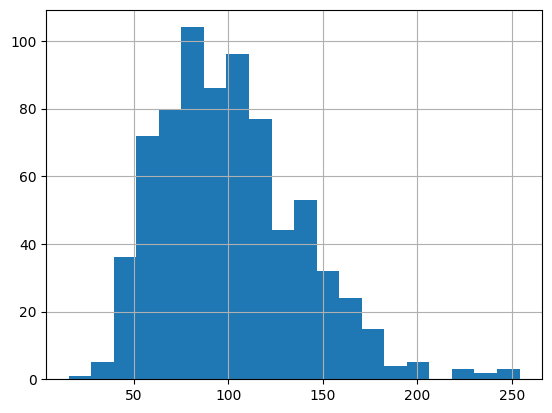

In [90]:
df['Avg Salary(K)'].hist(bins=20)

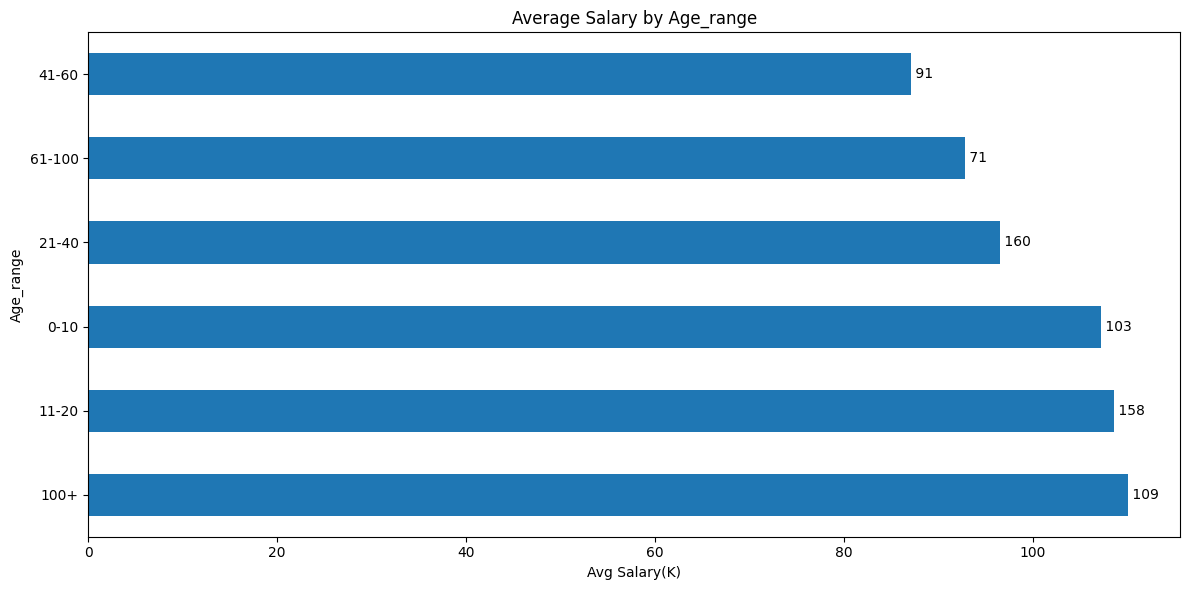

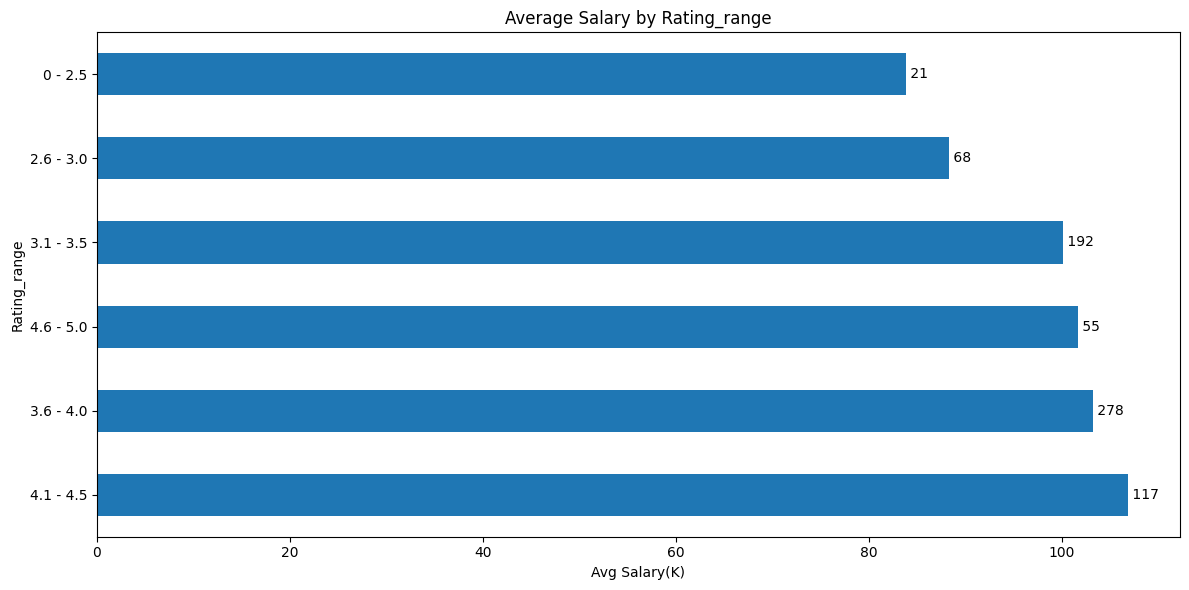

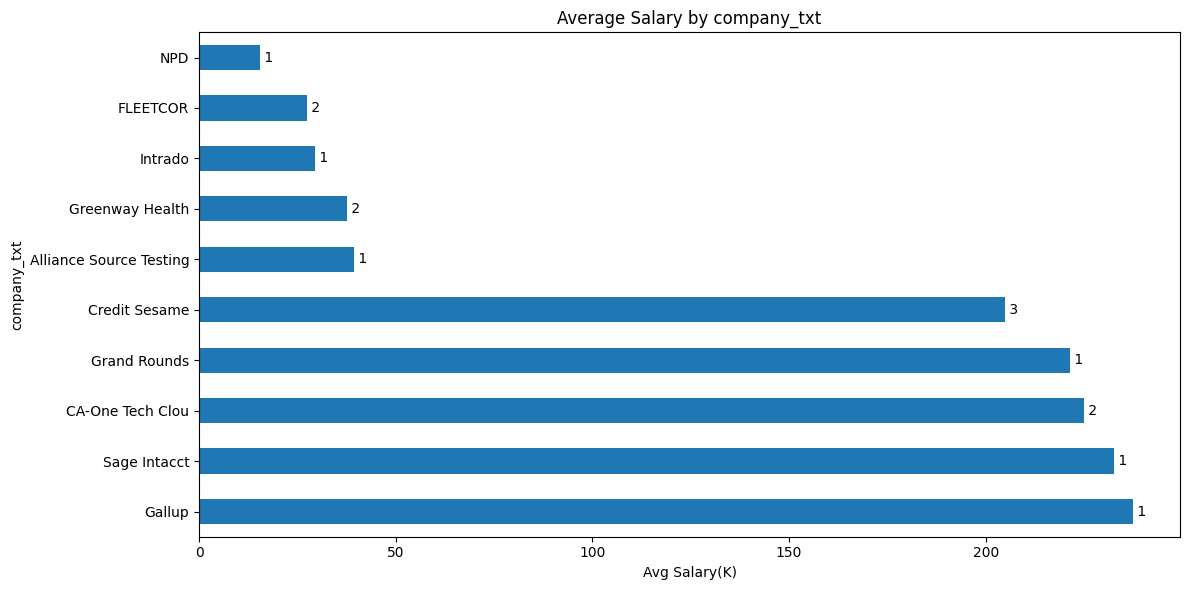

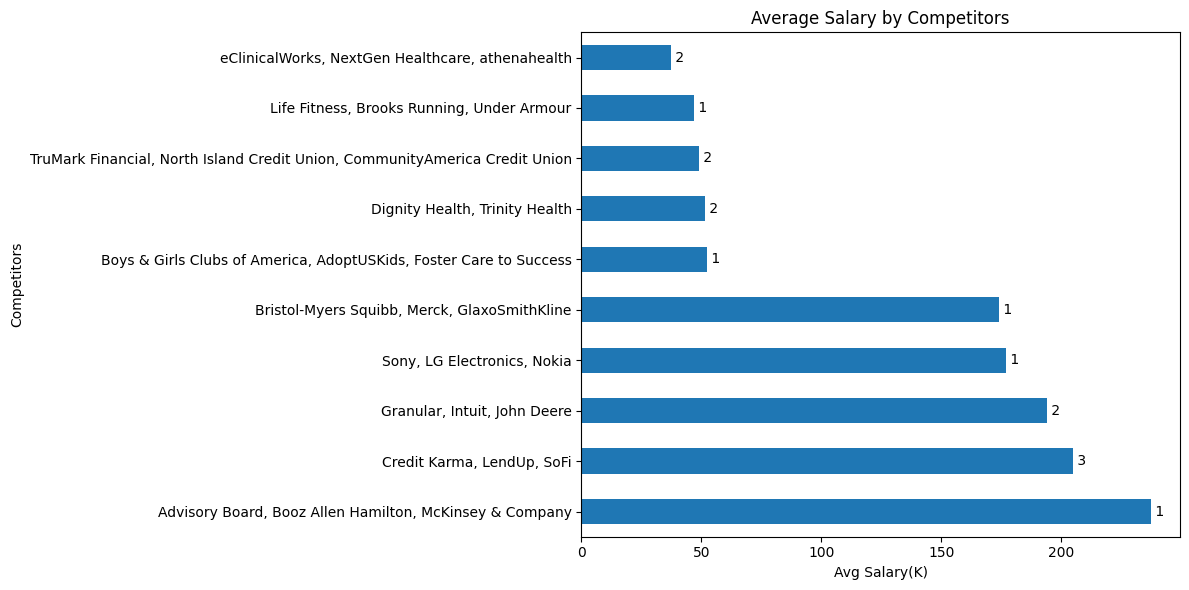

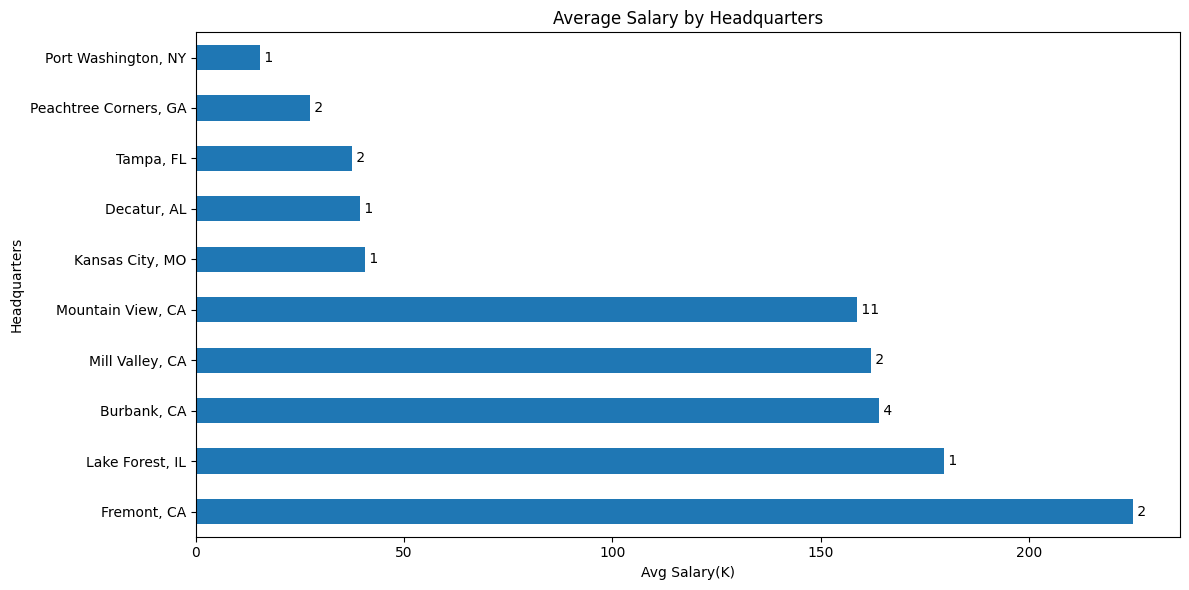

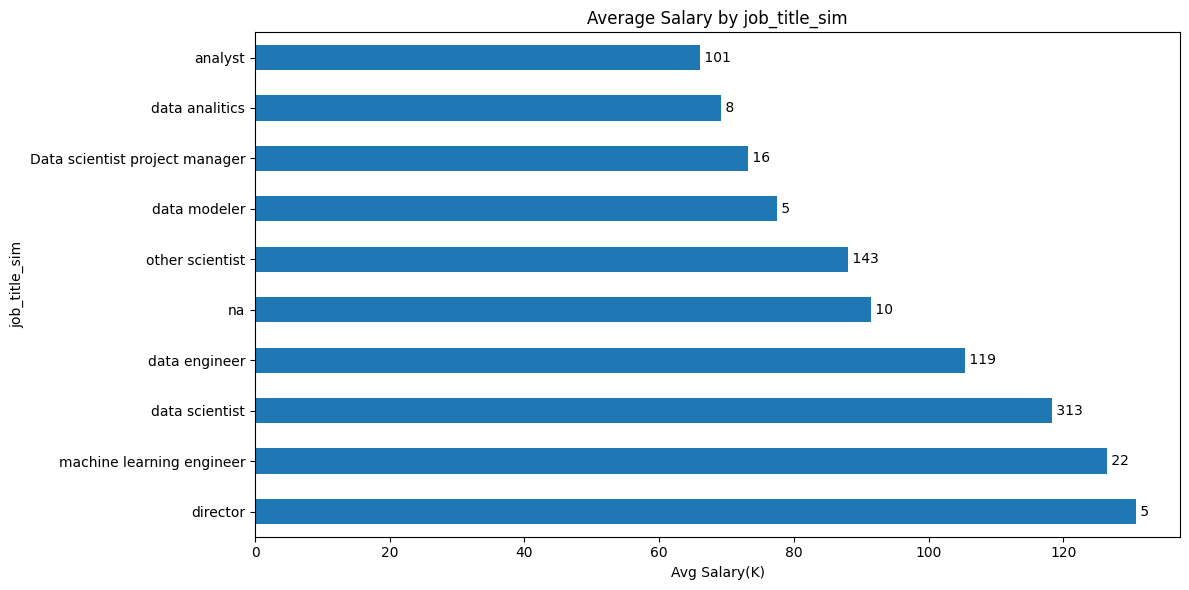

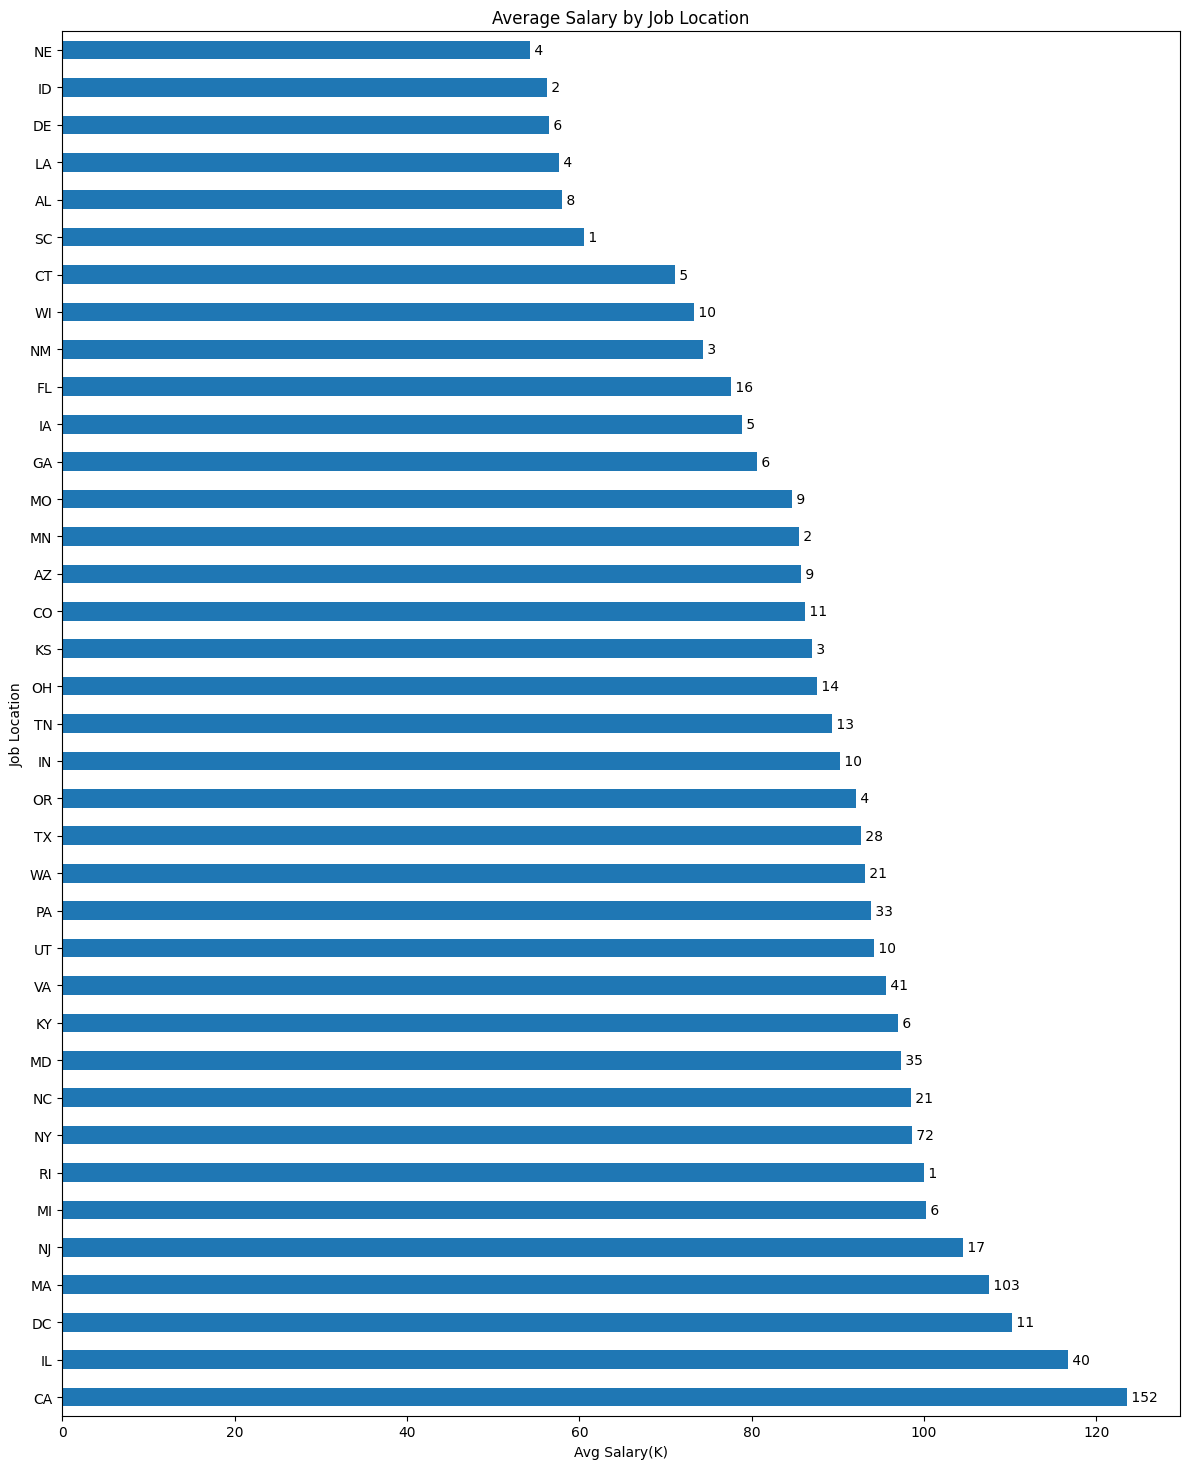

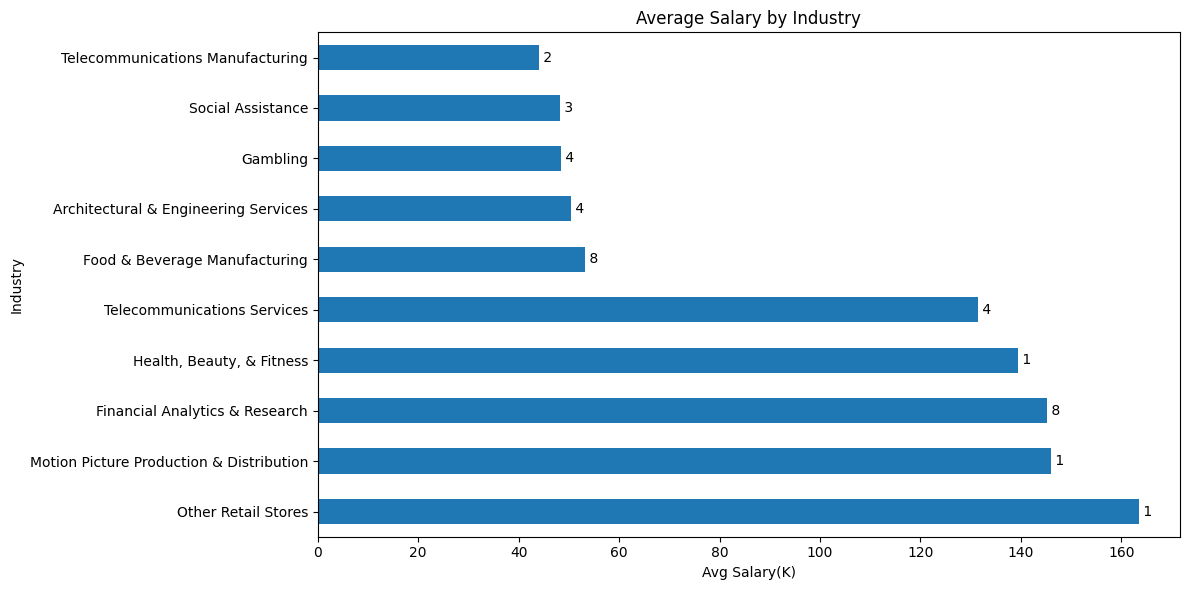

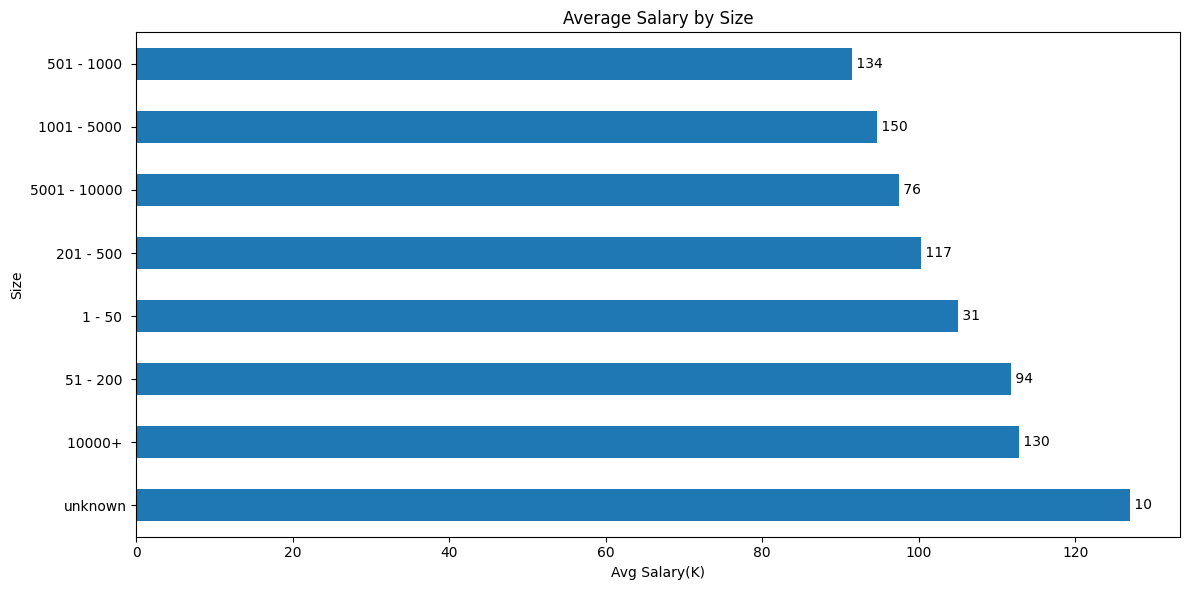

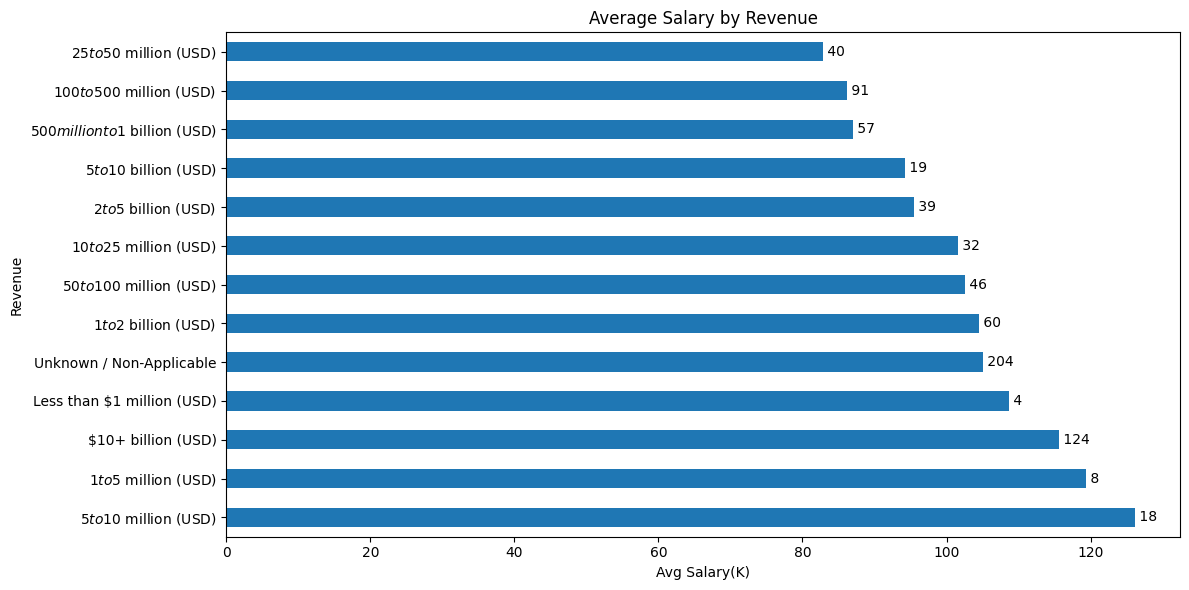

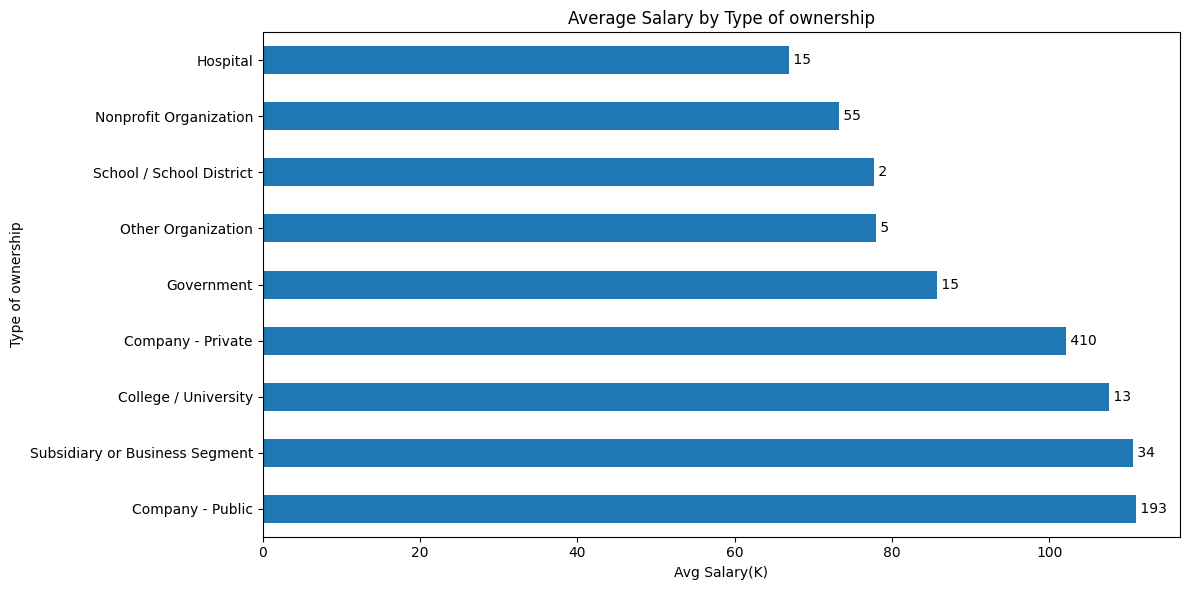

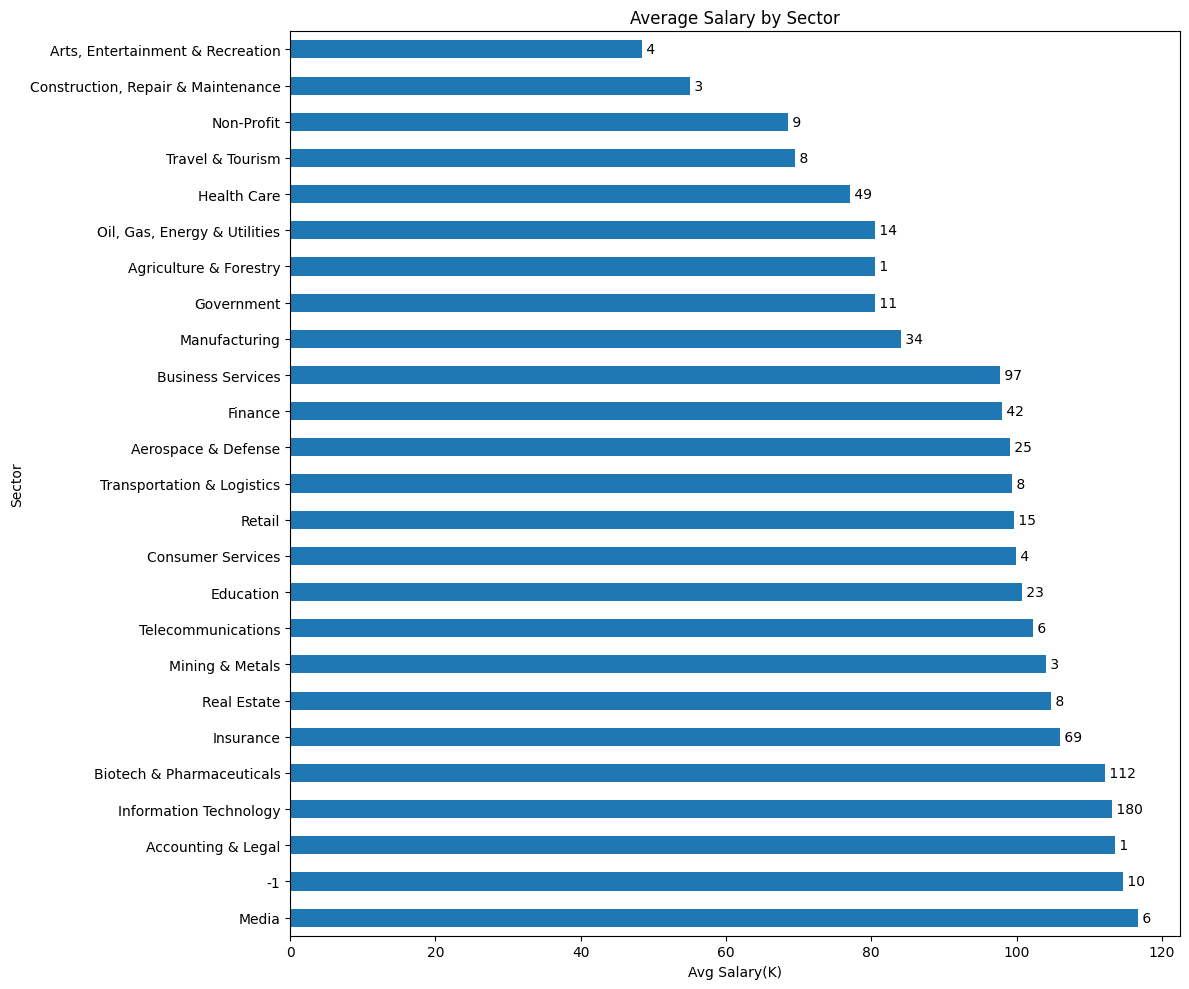

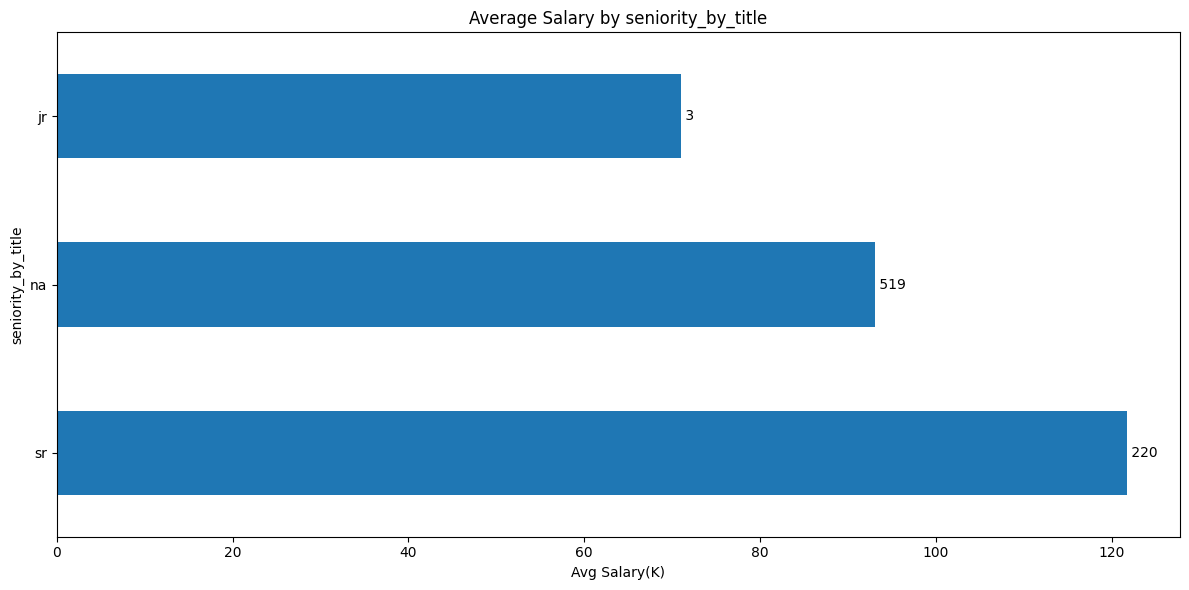

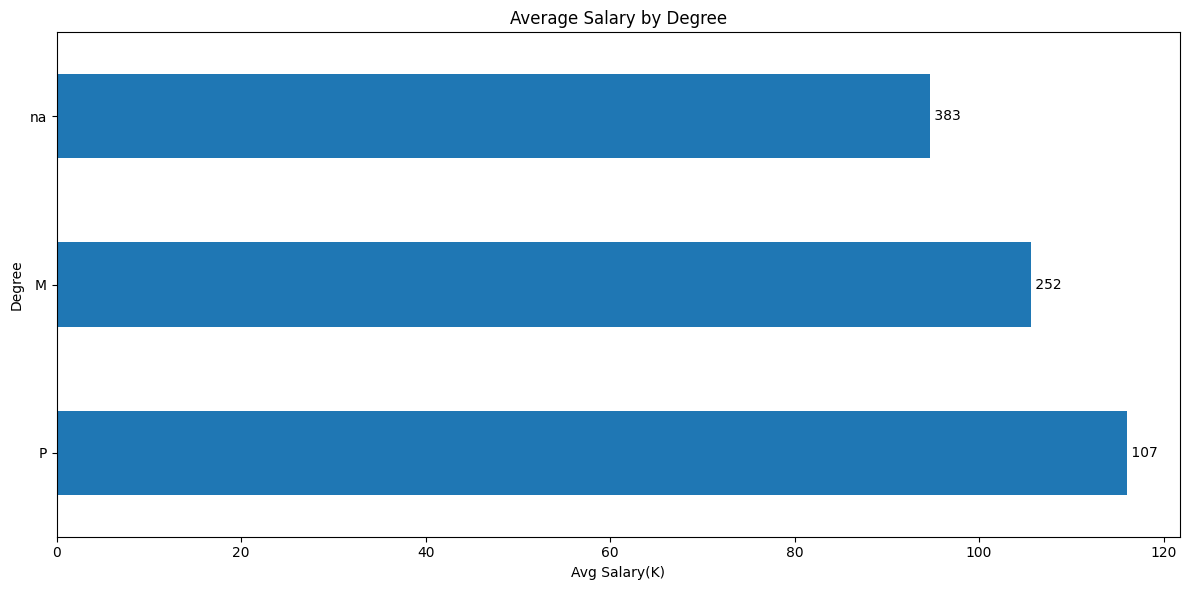

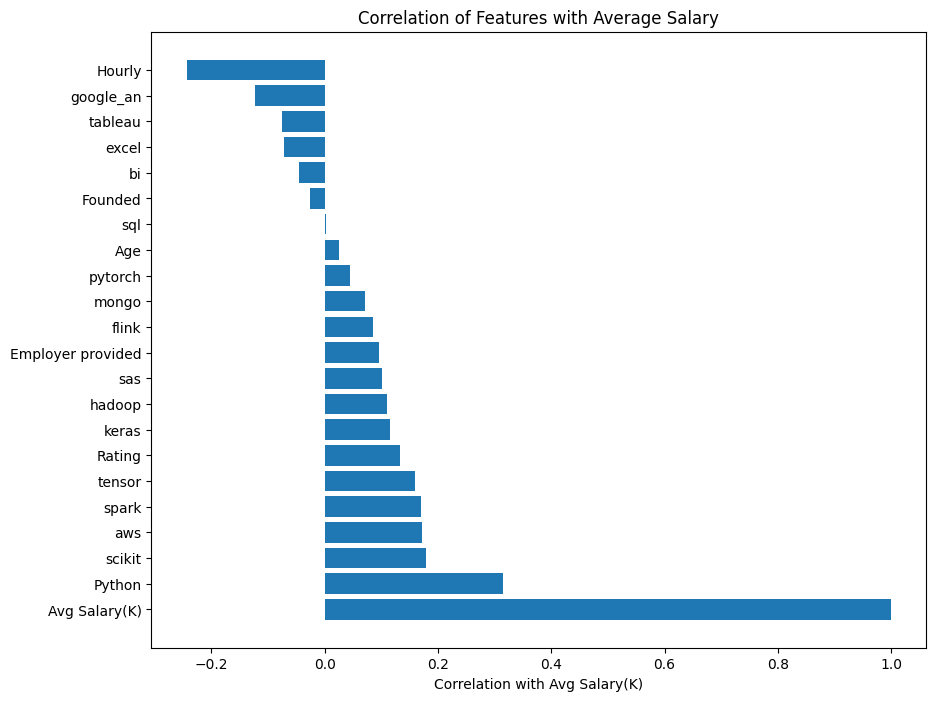

In [91]:
def plot_avg_salary_by_category(df, category_col):
    avg_salary = df.groupby(category_col, observed=False)['Avg Salary(K)'].mean().sort_values(ascending=False)
    counts = df[category_col].value_counts()
    n = len(avg_salary)
    
    if n > 50:
        avg_salary = pd.concat([avg_salary.head(5), avg_salary.tail(5)])

    height = min(max(len(avg_salary) * 0.4, 6), 20)
    plt.figure(figsize=(12, height))
    bars = avg_salary.plot(kind='barh')
    
    for i, (cat, val) in enumerate(avg_salary.items()):
        total = counts.get(cat, 0)
        plt.text(val, i, f' {total}', va='center', fontsize=10, color='black')
    plt.title(f'Average Salary by {category_col}')
    plt.xlabel('Avg Salary(K)')
    plt.tight_layout()
    plt.show()

category_columns = ['Age_range', 'Rating_range','company_txt', 'Competitors', 'Headquarters', 'job_title_sim', 'Job Location', 'Industry',  'Size', 'Revenue', 'Type of ownership', 'Sector', 'seniority_by_title', 'Degree']

for category in category_columns:
    plot_avg_salary_by_category(df, category)


skill_columns = ['Python', 'spark', 'aws', 'excel', 'sql', 'sas', 'keras', 'pytorch',
                 'scikit', 'tensor', 'hadoop', 'tableau', 'bi', 'flink', 'mongo', 'google_an']

# Ter certeza de que as colunas de habilidades são do tipo int
df[skill_columns] = df[skill_columns].fillna(0).astype(int)

# Adicionar essas colunas numéricas à análise
df_corr = df[['Avg Salary(K)', 'Rating', 'Founded', 'Age', 'Employer provided', 'Hourly'] + skill_columns]

# Calcular correlação e ordenar
correlation = df_corr.corr()
corr_with_salary = correlation['Avg Salary(K)'].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(corr_with_salary.index, corr_with_salary.values)
plt.xlabel('Correlation with Avg Salary(K)')
plt.title('Correlation of Features with Average Salary')
plt.show()


In [92]:
import plotly.express as px

state_salary = df.groupby('Job Location')['Avg Salary(K)'].mean().reset_index()

fig = px.choropleth(
    state_salary,
    locations='Job Location',
    locationmode="USA-states",
    color='Avg Salary(K)',
    color_continuous_scale="bluered",
    scope="usa",
    labels={'Avg Salary(K)': 'Avg Salary (K)'},
    title='Salário médio por estado dos EUA',
)
fig.update_layout(width=1000, height=700)
fig.show()

In [93]:
import pandas as pd

# Análise de impacto de skills no salário
skill_impact = {}
for skill in skill_columns:
    has_skill = df[df[skill] == 1]['Avg Salary(K)'].mean()
    no_skill = df[df[skill] == 0]['Avg Salary(K)'].mean()
    skill_impact[skill] = {
        'with_skill': has_skill,
        'without_skill': no_skill,
        'difference': has_skill - no_skill,
        'percentage_increase': ((has_skill - no_skill) / no_skill) * 100
    }

# Ordenar por impacto
sorted_skills = sorted(skill_impact.items(), 
                      key=lambda x: x[1]['difference'], reverse=True)

# Exibir resultados

# Exibir todos os resultados completos em formato de DataFrame
df_skill_impact = pd.DataFrame([
    {
        'Skill': skill,
        'Com habilidade (K)': impact['with_skill'],
        'Sem habilidade (K)': impact['without_skill'],
        'Aumento (%)': impact['percentage_increase'],
        'Qtd com habilidade': df[df[skill] == 1].shape[0],
        'Confiabilidade dos dados': 'Maior' if df[df[skill] == 1].shape[0] > 100 else 'Menor'
    }
    for skill, impact in sorted_skills
])

# Ordena primeiro por confiabilidade (Alta antes), depois por diferença (K) decrescente
df_skill_impact['Confiabilidade dos dados'] = pd.Categorical(
    df_skill_impact['Confiabilidade dos dados'], categories=['Maior', 'Menor'], ordered=True
)

df_skill_impact = df_skill_impact.sort_values(
    by=['Confiabilidade dos dados', 'Aumento (%)'], ascending=[True, False]
).reset_index(drop=True)

# Configura o pandas para mostrar todas as linhas e colunas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(df_skill_impact)

,Skill,Com habilidade (K),Sem habilidade (K),Aumento (%),Qtd com habilidade,Confiabilidade dos dados
0,Python,112.653061,88.975714,26.611022,392,Maior
1,spark,113.347305,98.039130,15.614352,167,Maior
2,aws,113.082386,97.878092,15.533910,176,Maior
3,hadoop,110.729839,99.629450,11.141674,124,Maior
4,sql,101.557895,101.407459,0.148348,380,Maior
5,excel,98.896907,104.320621,-5.199082,388,Maior
6,tableau,95.875000,102.882155,-6.810855,148,Maior
7,flink,129.000000,101.108607,27.585578,10,Menor
8,scikit,125.314815,99.614099,25.800280,54,Menor
9,keras,122.965517,100.610799,22.219004,29,Menor


## Treinamento e teste

### Funções de treinamento

#### GridSearchCV

In [94]:
def train_and_evaluate(pipeline, estimator, param_grid, 
                    X_train, y_train, X_test, y_test):

    """
    Combina pipeline (pré-processamento + seleção) com modelo,
    executa GridSearchCV e retorna grid e métricas de teste.
    """

    full_pipe = Pipeline([('pipe', pipeline),
                          ('model', estimator)])
    
    # Constrói o param_grid para GridSearchCV
    gs_params = {}
    for key, values in param_grid.items():
        if '__' in key:
            # parãmetro de pipeline (como 'kbest__k')
            gs_params[f'pipe__{key}'] = values
        else:
            # parâmetro do estimador (como 'alpha')
            gs_params[f'model__{key}'] = values

    grid = GridSearchCV(
        full_pipe,
        param_grid=gs_params,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    grid.fit(X_train, y_train)
    
    # Previsão com melhor modelo encontrado
    best_estimator = grid.best_estimator_
    y_pred = best_estimator.predict(X_test)
    
    # Cálculo de métricas
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    
    return {        
        'best_estimator': best_estimator,
        'best_params': grid.best_params_,
        'best_score': grid.best_score_,
        'cv_results': grid.cv_results_,
        'y_pred': y_pred,
        'mae': mae,
        'rmse': rmse,        
        'r2': r2
    }

### Divisão do dataset em treino e teste

In [95]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Execução dos modelos

#### Lasso

In [96]:
# Regressão Linear com regularização L1
estimator_lasso = Lasso(
    random_state=42,    
    max_iter=3000,      # Aumentar iterações para garantir convergência
    tol=1e-5,           # Tolerância mais restrita
    warm_start=True     # Acelerar convergência em grid search
)

param_grid_lasso = {
    'alpha': [0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 2.0]
}

result_lasso = train_and_evaluate(
    pipeline_seq,
    estimator_lasso,
    param_grid_lasso,
    X_train, 
    y_train,
    X_test,   
    y_test
)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


In [58]:
print
(            
        f"| MAE: {result_lasso['mae']:.2f} "
        f"| RMSE: {result_lasso['rmse']:.2f} "
        f"| R²: {result_lasso['r2']:.4f} |"
)

'| MAE: 18.84 | RMSE: 25.19 | R²: 0.5954 |'

#### RandomForest

In [42]:
estimator_rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200, 400],         # Número de árvores na floresta
    'max_depth': [3, 5, 10, None],           # Profundidade máxima das árvores
    'min_samples_split': [2, 5],        # Número mínimo de amostras necessárias para dividir um nó      
    'max_features': ['sqrt', 'log2', None], # Número de recursos a serem considerados ao procurar a melhor divisão
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1]         # Parâmetro de complexidade para poda   
}

result_rf = train_and_evaluate(
    pipeline_seq,
    estimator_rf,
    param_grid_rf,
    X_train, 
    y_train,
    X_test,  
    y_test
)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


#### XGBoost

In [61]:
estimator_xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

param_grid_xgb = {
    'n_estimators': [700, 900],
    'learning_rate': [0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8],
    'alpha': [0, 1, 10],
    'lambda': [1, 10],
    'ccp_alpha': [0, 0.001, 0.01, 0.1]
}

result_xgb = train_and_evaluate(
    pipeline_seq,
    estimator_xgb,
    param_grid_xgb,
    X_train, 
    y_train,
    X_test,   
    y_test
)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


c:\Users\duike\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning:

[12:23:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "ccp_alpha" } are not used.




## Resultados

### Melhores combinações de hiperparâmetros

In [99]:
# Imprime melhores parâmetros, melhor score e top N combos de hiperparâmetros
def print_search_results(result, model_name, top_n=20):
    print(
        f"Modelo {model_name} \n\n"
        f"Melhores parâmetros: {result['best_params']} \n"
        f"Melhor score médio: {result['best_score']:.4f} \n\n"
        f"Top {top_n} combinações de hiperparâmetros:"
    )
    df = pd.DataFrame(result['cv_results'])
    display(df.sort_values(by='mean_test_score', ascending=False).head(top_n))

#### Lasso

In [100]:
print_search_results(result_lasso, "Lasso")

Modelo Lasso 

Melhores parâmetros: {'model__alpha': 0.05} 
Melhor score médio: 0.5378 

Top 20 combinações de hiperparâmetros:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,8.164781,0.674909,0.008622,0.000377,0.05,{'model__alpha': 0.05},0.488073,0.472041,0.577659,0.550110,0.601276,0.537832,0.050133,1
1,8.446765,1.032271,0.012257,0.004615,0.01,{'model__alpha': 0.01},0.482871,0.460836,0.581154,0.536340,0.601721,0.532584,0.054355,2
0,8.252130,0.768352,0.011521,0.006026,0.005,{'model__alpha': 0.005},0.478398,0.457408,0.580044,0.531422,0.599253,0.529305,0.055195,3
3,8.217593,0.483341,0.008221,0.000401,0.1,{'model__alpha': 0.1},0.452882,0.452213,0.542632,0.515848,0.569161,0.506547,0.047205,4
4,8.232666,0.631965,0.007231,0.001029,0.5,{'model__alpha': 0.5},0.421968,0.382407,0.438027,0.449724,0.504140,0.439253,0.039628,5
5,7.947378,0.653536,0.006518,0.000708,1.0,{'model__alpha': 1.0},0.387920,0.358492,0.414045,0.405094,0.480344,0.409179,0.040314,6
6,6.517032,0.789583,0.006050,0.001005,2.0,{'model__alpha': 2.0},0.323535,0.316125,0.346301,0.346993,0.403639,0.347318,0.030698,7


#### RandomForest

In [626]:
print_search_results(result_rf, "RandomForest")

Modelo RandomForest 

Melhores parâmetros: {'model__ccp_alpha': 0.0, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 50} 
Melhor score médio: 0.0054 

Top 20 combinações de hiperparâmetros:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__ccp_alpha,param_model__max_depth,param_model__max_features,param_model__min_samples_split,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.430638,0.028968,0.018352,0.003453,0.0,3,sqrt,2,50,"{'model__ccp_alpha': 0.0, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
72,5.322394,0.550238,0.055590,0.018369,0.0,None,sqrt,2,50,"{'model__ccp_alpha': 0.0, 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
148,4.336772,0.220322,0.042868,0.017529,0.001,10,sqrt,5,50,"{'model__ccp_alpha': 0.001, 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
144,4.430226,0.107428,0.036875,0.011083,0.001,10,sqrt,2,50,"{'model__ccp_alpha': 0.001, 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
292,4.519250,0.142299,0.037794,0.005603,0.1,3,sqrt,5,50,"{'model__ccp_alpha': 0.1, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
140,4.464045,0.263963,0.040219,0.011984,0.001,5,None,5,50,"{'model__ccp_alpha': 0.001, 'model__max_depth': 5, 'model__max_features': None, 'model__min_samples_split': 5, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
296,4.344939,0.061868,0.036010,0.003986,0.1,3,log2,2,50,"{'model__ccp_alpha': 0.1, 'model__max_depth': 3, 'model__max_features': 'log2', 'model__min_samples_split': 2, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
136,4.607721,0.068631,0.036645,0.002774,0.001,5,None,2,50,"{'model__ccp_alpha': 0.001, 'model__max_depth': 5, 'model__max_features': None, 'model__min_samples_split': 2, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
300,4.633860,0.370526,0.045091,0.011384,0.1,3,log2,5,50,"{'model__ccp_alpha': 0.1, 'model__max_depth': 3, 'model__max_features': 'log2', 'model__min_samples_split': 5, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
132,4.814126,0.281362,0.051147,0.010643,0.001,5,log2,5,50,"{'model__ccp_alpha': 0.001, 'model__max_depth': 5, 'model__max_features': 'log2', 'model__min_samples_split': 5, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1


#### XGBoost

In [627]:
print_search_results(result_xgb, "XGBoost")

Modelo XGBoost 

Melhores parâmetros: {'model__alpha': 10, 'model__ccp_alpha': 0.01, 'model__colsample_bytree': 0.6, 'model__lambda': 10, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 900, 'model__subsample': 1.0} 
Melhor score médio: 0.2576 

Top 20 combinações de hiperparâmetros:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__ccp_alpha,param_model__colsample_bytree,param_model__lambda,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
495,4.092744,0.158316,0.012935,0.001169,10,0.01,0.6,10,0.2,3,900,1.0,"{'model__alpha': 10, 'model__ccp_alpha': 0.01, 'model__colsample_bytree': 0.6, 'model__lambda': 10, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 900, 'model__subsample': 1.0}",-0.015292,0.064699,0.617583,-0.003766,0.624811,0.257607,0.298136,1
484,5.461634,1.374761,0.030938,0.036391,10,0.01,0.6,1,0.2,5,700,0.8,"{'model__alpha': 10, 'model__ccp_alpha': 0.01, 'model__colsample_bytree': 0.6, 'model__lambda': 1, 'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 700, 'model__subsample': 0.8}",-0.012198,0.614508,-0.015481,-0.005111,0.691562,0.254656,0.326204,2
525,4.462637,1.490756,0.013407,0.001449,10,0.01,0.8,10,0.2,7,700,1.0,"{'model__alpha': 10, 'model__ccp_alpha': 0.01, 'model__colsample_bytree': 0.8, 'model__lambda': 10, 'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 700, 'model__subsample': 1.0}",-0.015292,0.064699,0.557603,-0.003766,0.658898,0.252428,0.293565,3
346,3.566868,0.113987,0.012156,0.001809,1,0.1,0.6,1,0.2,7,900,0.8,"{'model__alpha': 1, 'model__ccp_alpha': 0.1, 'model__colsample_bytree': 0.6, 'model__lambda': 1, 'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 900, 'model__subsample': 0.8}",-0.014134,0.064812,-0.020396,-0.003300,0.690949,0.143586,0.275373,4
532,3.926422,0.297641,0.012596,0.000968,10,0.1,0.6,1,0.2,5,700,0.8,"{'model__alpha': 10, 'model__ccp_alpha': 0.1, 'model__colsample_bytree': 0.6, 'model__lambda': 1, 'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 700, 'model__subsample': 0.8}",-0.012198,0.064778,-0.015481,-0.005111,0.675715,0.141541,0.268713,5
283,4.749396,2.289218,0.020535,0.015773,1,0.001,0.8,10,0.2,5,900,1.0,"{'model__alpha': 1, 'model__ccp_alpha': 0.001, 'model__colsample_bytree': 0.8, 'model__lambda': 10, 'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 900, 'model__subsample': 1.0}",-0.015430,0.064849,-0.018421,-0.003835,0.678758,0.141184,0.270498,6
236,4.767534,2.661734,0.040235,0.055951,1,0,0.8,10,0.2,7,700,0.8,"{'model__alpha': 1, 'model__ccp_alpha': 0, 'model__colsample_bytree': 0.8, 'model__lambda': 10, 'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 700, 'model__subsample': 0.8}",-0.012137,0.064781,-0.015513,-0.005097,0.672183,0.140843,0.267304,7
499,5.008034,1.277465,0.013498,0.002897,10,0.01,0.6,10,0.2,5,900,1.0,"{'model__alpha': 10, 'model__ccp_alpha': 0.01, 'model__colsample_bytree': 0.6, 'model__lambda': 10, 'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 900, 'model__subsample': 1.0}",-0.015292,0.064699,-0.018550,-0.003766,0.676953,0.140809,0.269781,8
441,4.188407,1.714863,0.018527,0.013295,10,0.001,0.6,1,0.2,7,700,1.0,"{'model__alpha': 10, 'model__ccp_alpha': 0.001, 'model__colsample_bytree': 0.6, 'model__lambda': 1, 'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 700, 'model__subsample': 1.0}",-0.015292,0.064699,-0.018550,-0.003766,0.676823,0.140783,0.269729,9
260,3.453840,0.058237,0.012546,0.001241,1,0.001,0.6,10,0.2,7,700,0.8,"{'model__alpha': 1, 'model__ccp_alpha': 0.001, 'model__colsample_bytree': 0.6, 'model__lambda': 10, 'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 700, 'model__subsample': 0.8}",-0.012137,0.064781,-0.015513,-0.005097,0.670481,0.140503,0.266627,10


### Medidas de desempenho

In [63]:
def print_metrics(result, model_name):         
        print(
            f"{model_name} → "            
            f"| MAE: {result['mae']:.2f} "
            f"| RMSE: {result['rmse']:.2f} "
            f"| R²: {result['r2']:.4f} |"
        )

for name, result in [
    ("Lasso", result_lasso),
    ("RandomForest", result_rf),
    ("XGBoost", result_xgb)
]:
    print_metrics(result, name)

Lasso → | MAE: 18.84 | RMSE: 25.19 | R²: 0.5954 |
RandomForest → | MAE: 13.15 | RMSE: 20.05 | R²: 0.7437 |
XGBoost → | MAE: 11.37 | RMSE: 19.77 | R²: 0.7507 |


## Gráficos

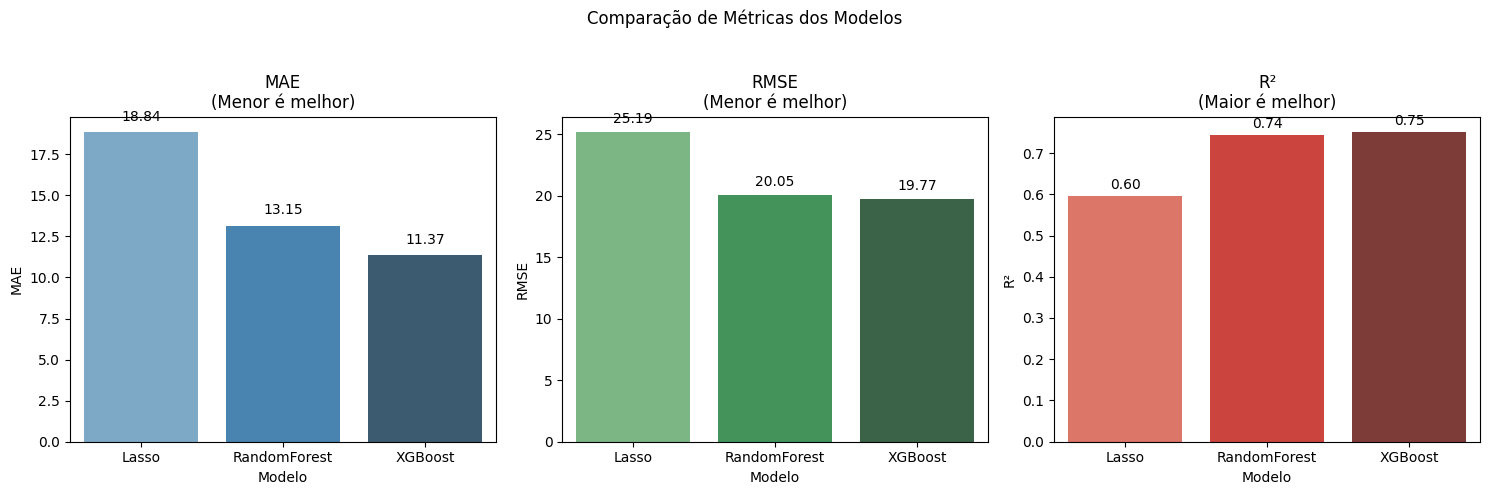

In [75]:
model_names = ["Lasso", "RandomForest", "XGBoost"]
mae_values = [result_lasso['mae'], result_rf['mae'], result_xgb['mae']]
rmse_values = [result_lasso['rmse'], result_rf['rmse'], result_xgb['rmse']]
r2_values = [result_lasso['r2'], result_rf['r2'], result_xgb['r2']]

metrics_df = pd.DataFrame({
    'Modelo': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R²': r2_values
})

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MAE
sns.barplot(x='Modelo', y='MAE', hue='Modelo', data=metrics_df, ax=axes[0], palette='Blues_d', legend=False)
axes[0].set_title('MAE\n(Menor é melhor)')
axes[0].set_ylabel('MAE')
for i, v in enumerate(metrics_df['MAE']):
    axes[0].text(i, v + 0.5, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

# RMSE
sns.barplot(x='Modelo', y='RMSE', hue='Modelo', data=metrics_df, ax=axes[1], palette='Greens_d', legend=False)
axes[1].set_title('RMSE\n(Menor é melhor)')
axes[1].set_ylabel('RMSE')
for i, v in enumerate(metrics_df['RMSE']):
    axes[1].text(i, v + 0.5, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

# R²
sns.barplot(x='Modelo', y='R²', hue='Modelo', data=metrics_df, ax=axes[2], palette='Reds_d', legend=False)
axes[2].set_title('R²\n(Maior é melhor)')
axes[2].set_ylabel('R²')
for i, v in enumerate(metrics_df['R²']):
    axes[2].text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

plt.suptitle('Comparação de Métricas dos Modelos')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Reais vs Preditos

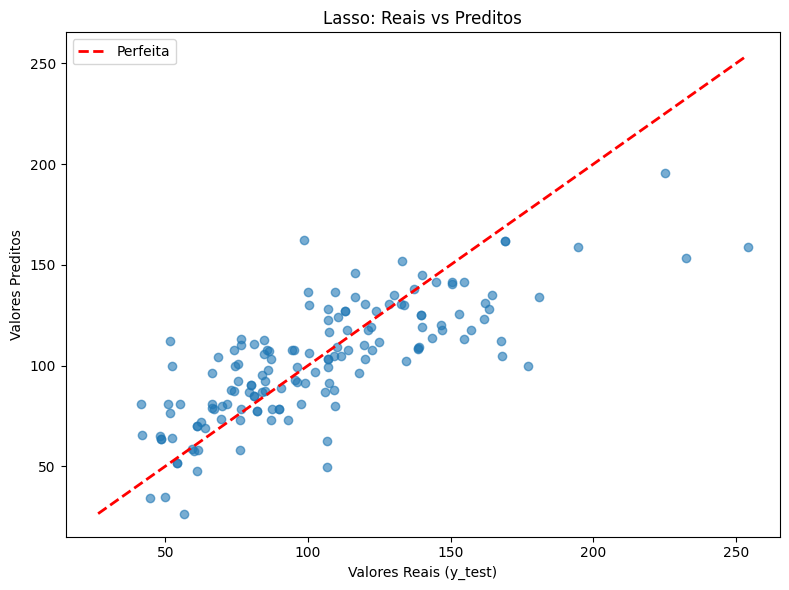

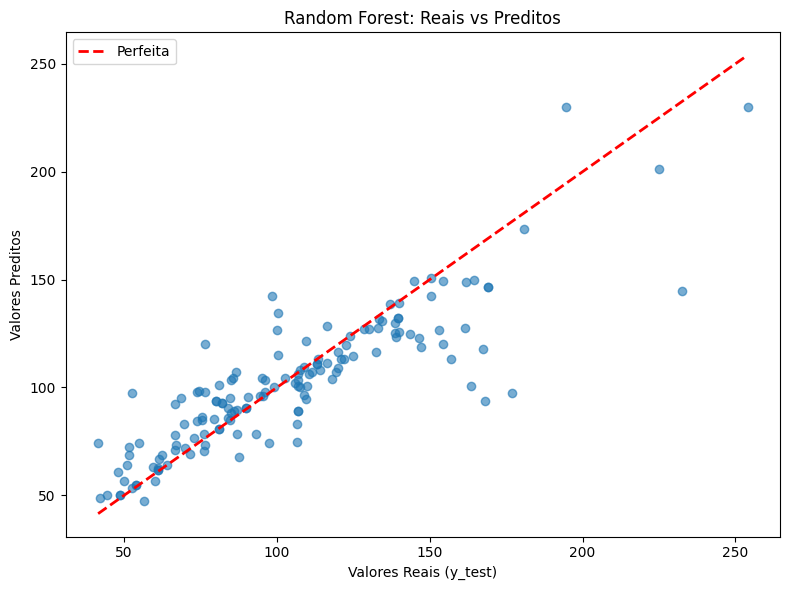

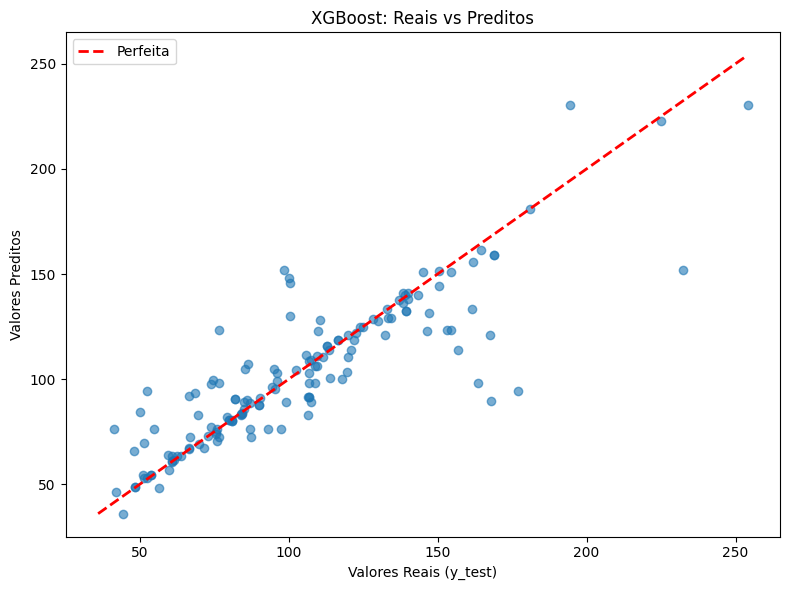

In [76]:
def plot_predicted_vs_actual(result, model_name, y_test):
    y_pred = result['y_pred']
    
    # Scatter
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)

    # Linha identidade
    lim_min = min(y_test.min(), y_pred.min())
    lim_max = max(y_test.max(), y_pred.max())
    plt.plot([lim_min, lim_max], [lim_min, lim_max], color='red', linestyle='--', lw=2, label='Perfeita')

    plt.xlabel("Valores Reais (y_test)")
    plt.ylabel("Valores Preditos")
    plt.title(f"{model_name}: Reais vs Preditos")
    plt.legend()
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Lasso", result_lasso),
    ("Random Forest", result_rf),
    ("XGBoost", result_xgb),
    
]:
    plot_predicted_vs_actual(result, name, y_test)

#### Distribuição dos resíduos

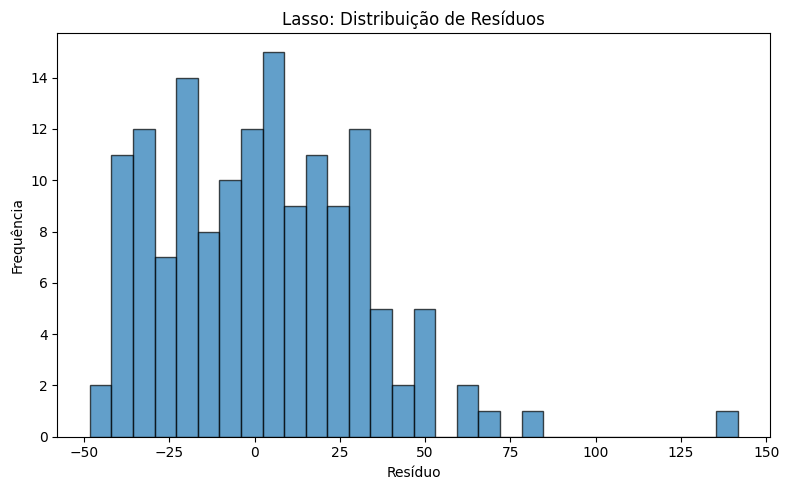

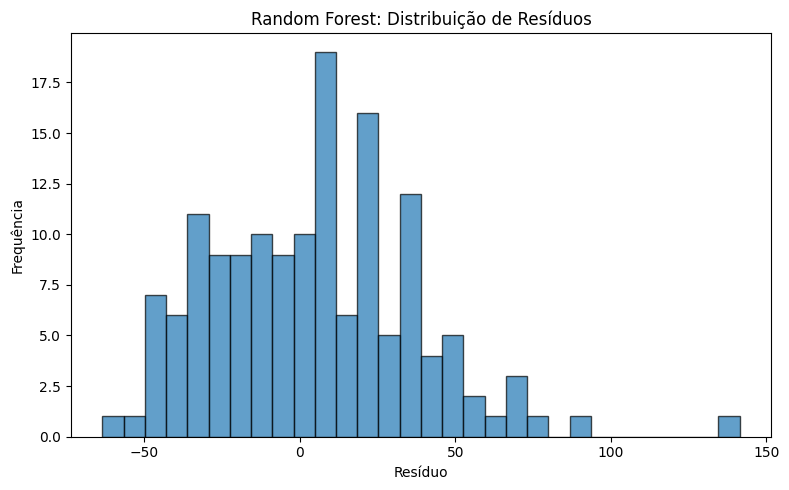

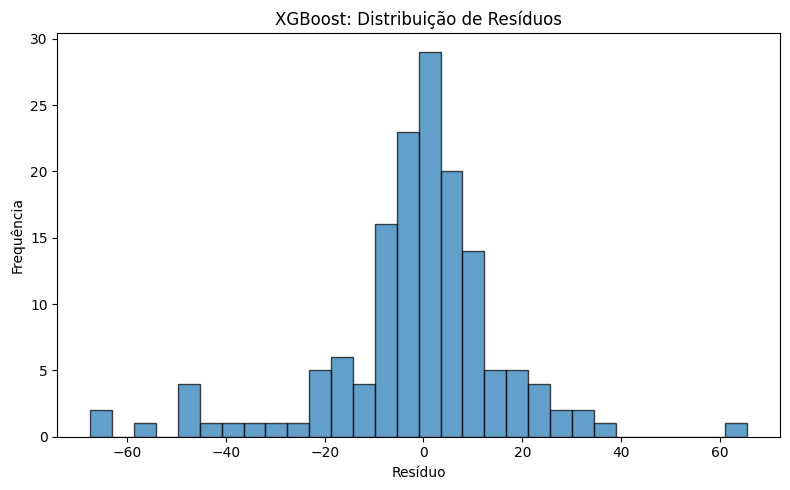

In [ ]:
def plot_residuals_hist(result, model_name, y_test):
    y_pred = result['y_pred']
    residuals = y_test - y_pred
    
    plt.figure(figsize=(8,5))
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel("Resíduo")
    plt.ylabel("Frequência")
    plt.title(f"{model_name}: Distribuição de Resíduos")
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Lasso", result_lasso),
    ("Random Forest", result_rf),
    ("XGBoost", result_xgb)
]:
    plot_residuals_hist(result, name, y_test)

#### Curva de Aprendizado

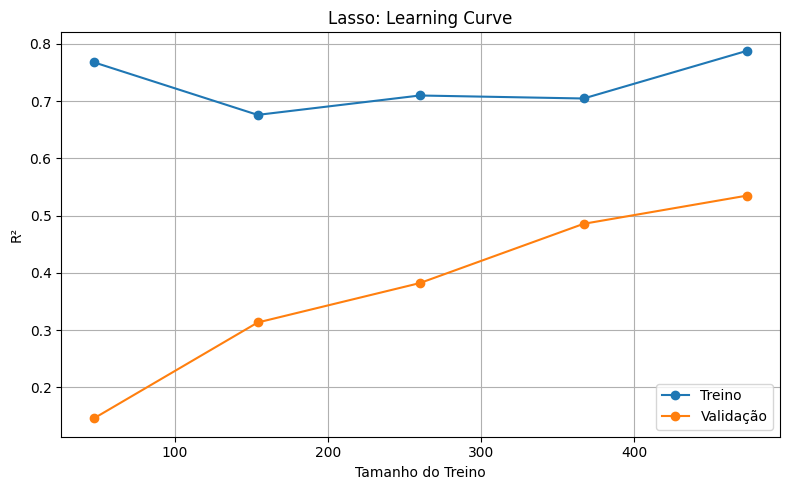

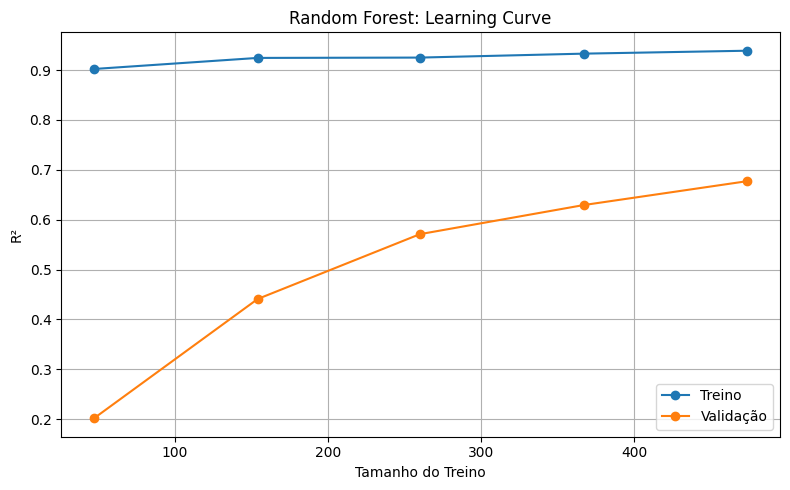

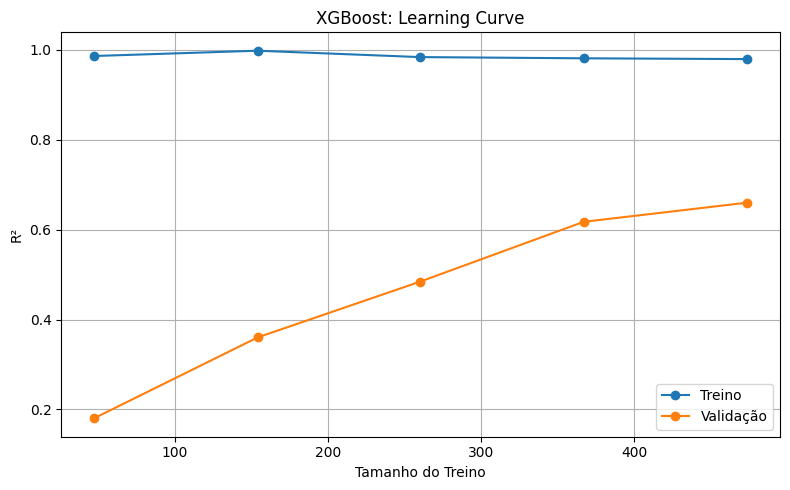

In [79]:
def plot_learning_curve(result, model_name, X_train, y_train, cv=5):
    model = result['best_estimator']

    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=cv,
        train_sizes=np.linspace(.1, 1.0, 5),
        scoring='r2', n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean   = np.mean(val_scores,   axis=1)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, 'o-', label='Treino')
    plt.plot(train_sizes, val_mean,   'o-', label='Validação')
    plt.xlabel("Tamanho do Treino")
    plt.ylabel("R²")
    plt.title(f"{model_name}: Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Lasso", result_lasso),
    ("Random Forest", result_rf),
    ("XGBoost", result_xgb)
]:
    plot_learning_curve(result, name, X_train, y_train)

